<a href="https://colab.research.google.com/github/GabrielMiranda3857/TP4/blob/main/C%C3%B3pia_de_Valgrind_Simulador_de_Cache.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Valgrind e  Simulação de Cache: **Cachegrind**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Este laboratório apresenta o uso da ferramenta cachegrind do ambiente Valgrind, [para maiores informações consulte aqui](https://valgrind.org/docs/manual/cg-manual.html)

**Importante**: 
* A primeira execução do Cachegrind irá fazer a instalação da ferramenta e pode demorar um pouco mais. 
* Os laboratorios usam uma multiplicação de matrizes como exemplo. O tamanho da matriz cresce com  $O(N^2)$ e o tempo de execução com $O(N^3)$.
* Os exemplos estão em C. Mas o Cachegrind trabalha sobre o executável e pode ser usado em qualquer binário. 
* Fique a vontade para contribuir.


## Inicialização

Primeiro, configurar o laboratório.

In [ ]:
!pip install git+git://github.com/canesche/nvcc4jupyter.git
!git clone https://github.com/canesche/nvcc4jupyter
%load_ext nvcc_plugin

  Cloning git://github.com/canesche/nvcc4jupyter.git to /tmp/pip-req-build-g7zazhoj
  Running command git clone -q git://github.com/canesche/nvcc4jupyter.git /tmp/pip-req-build-g7zazhoj
  Created wheel for ColabPlugin: filename=ColabPlugin-blind-cp36-none-any.whl size=12717 sha256=3ba5b74a1b36e2317f8c7a1a99d1ef67f60e478ead9956280bd99214f3352e88
  Stored in directory: /tmp/pip-ephem-wheel-cache-m9_2y4wb/wheels/87/ae/09/21c6e192181a0472e20ddd1d5212e2cbb113f00ebe14330d0d
Successfully built ColabPlugin
Cloning into 'nvcc4jupyter'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (362/362), done.
remote: Compressing objects: 100% (271/271), done.
remote: Total 1147 (delta 100), reused 328 (delta 74), pack-reused 785
Receiving objects: 100% (1147/1147), 35.71 MiB | 21.05 MiB/s, done.
Resolving deltas: 100% (554/554), done.


# Specify all cache parameters

A extensão **\%\%cachegrind** é semelhante a linha de comando, importante que os tamanhos de cache devem ser potência de 2, a linha além de potência de 2 começa com 32 bytes. A ordem dos parametros é tamanho da cache, associatividade e tamanho da linha. Os flags para cache de dados, de instruções e de último nível são **D1**, **I1**, and **LL**, respectivamente.

In [ ]:
%%cachegrind --D1=32768,8,32 --I1=32768,2,32 --LL=65536,2,32 --file
#include <stdio.h>
#include <stdlib.h>

int main(int argc, char const *argv[]) {
  
  int n = 100;
  int a[n][n], b[n][n], c[n][n];
  
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
        a[i][j] = i + j;
        b[i][j] = i*2 + j;   
      }
  }
  
  int temp;
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
          temp = 0;
          for (int k = 0; k < n; ++k) {
              temp += a[i][k] * b[k][j];
          }
          c[i][j] = temp;   
      }
  } 
  return 0;
}

UsageError: Cell magic `%%cachegrind` not found.


## Atenção aos resultados 

Valgrind quando simula a cache ele também simula a inicialização do sistema.
Portanto, quando for utilizar o valgrind esteja ciente que se o seu código for muito simples será mascarado pela inicialização do sistema.

In [ ]:
%%cachegrind --D1=1024,8,32 --I1=32768,2,32 --LL=65536,2,32 --file

int main(int argc, char const *argv[]) {
  //# empty code
}

UsageError: Cell magic `%%cachegrind` not found.


## Exemplo de código mascarado

Abaixo é apresentado um código de **transposição de matrizes** sendo mascarado pela inicialização do sistema.




In [ ]:
%%cachegrind --D1=1024,8,32 --I1=32768,2,32 --LL=65536,2,32 --file
#include <stdio.h>
#include <stdlib.h>

#define n 32
int A[n][n], B[n][n];

void trans(int M, int N) { 
    int i, j, tmp;
    for (i = 0; i < N; i++)
        for (j = 0; j < M; j++) {
            tmp = A[i][j];
            B[j][i] = tmp;
        }   
}

int main(int argc, char const *argv[]) {
  for (int i = 0; i < n; ++i)
    for (int j = 0; j < n; ++j)
      A[i][j] = i + j;

  trans(n, n); //# transposição de matrizes
  return 0;
}

UsageError: Cell magic `%%cachegrind` not found.


## Resultados **somente inicialização X transposição de matrizes**

Somente Inicialização:
* D   refs:      1,203,059  (771,626 rd   + 431,433 wr)
* D1  misses:      284,860  (219,936 rd   +  64,924 wr)

Transposição de matrizes:
* D   refs:      1,221,822  (787,247 rd   + 434,575 wr)
* D1  misses:      286,147  (220,069 rd   +  66,078 wr)

Note que a diferença é pequena, sendo para a cache dados L1:
* D refs: 1221822 - 1203059 = 18763
* D1 misses: 286147 - 284860 = 1287

## Solução: Mais trabalho para o algoritmo

Uma solução é fazer com que o seu código der mais trabalho para cache de dados, assim a inicialização não irá mascarar os resultados.



### Tranposição simples

In [ ]:
%%cachegrind --D1=1024,8,32 --I1=32768,2,32 --LL=65536,2,32 --file
#include <stdio.h>
#include <stdlib.h>

#define n 32
int A[n][n], B[n][n];

void trans(int M, int N) { 
    int i, j, tmp;
    for (i = 0; i < N; i++)
        for (j = 0; j < M; j++) {
            tmp = A[i][j];
            B[j][i] = tmp;
        }   
}

int main(int argc, char const *argv[]) {
  for (int i = 0; i < n; ++i)
    for (int j = 0; j < n; ++j)
      A[i][j] = i + j;
      
  for (int i; i < 2000; ++i)
    trans(n, n); //# transposição de matrizes
  return 0;
}

UsageError: Cell magic `%%cachegrind` not found.


In [ ]:
%%cachegrind --D1=1024,8,32 --I1=32768,2,32 --LL=65536,2,32 --file
#include <stdio.h>
#include <stdlib.h>

#define n 32
int A[n][n], B[n][n];

void transpose_32_32(int M, int N) {
    int BLOCK_SIZE, rowIndex, colIndex, blockedRowIndex, blockedColIndex, eBlockDiagl, iBlockDiagl;
    BLOCK_SIZE = 8;        
    for (colIndex = 0; colIndex < M; colIndex += BLOCK_SIZE) {
        for (rowIndex = 0; rowIndex < N; rowIndex += BLOCK_SIZE) {
            for (blockedRowIndex = rowIndex; blockedRowIndex < rowIndex + BLOCK_SIZE; ++blockedRowIndex) {
                for (blockedColIndex = colIndex; blockedColIndex < colIndex + BLOCK_SIZE; ++blockedColIndex) {
                    if (blockedRowIndex != blockedColIndex)
                        B[blockedColIndex][blockedRowIndex] = A[blockedRowIndex][blockedColIndex];
                    else {
                        eBlockDiagl = A[blockedRowIndex][blockedColIndex];
                        iBlockDiagl = blockedRowIndex;
                    }
                }
                if (colIndex == rowIndex)
                    B[iBlockDiagl][iBlockDiagl] = eBlockDiagl;               
            }
        }
    } 
}

int main(int argc, char const *argv[]) {
  for (int i = 0; i < n; ++i)
    for (int j = 0; j < n; ++j)
      A[i][j] = i + j;
  for (int i; i < 2000; ++i)
    transpose_32_32(n, n); //# transposição de matrizes 32x32
  return 0;
}

UsageError: Cell magic `%%cachegrind` not found.


### Processando os dados: **Transposição simples X Transposição 32x32**

Note que a cache de dados teve maiores valores na transposição 32x32:

* Transposição simples: 24,144,358
* Transposição 32x32:   29,162,358

Contudo as falhas na transposição 32x32 foram menores:

* Transposição simples: 10.7%
* Transposição 32x32:   6.3%

Logo, quanto menos falha na cache L1 melhor.

# Variando o tamanho da Cache e visualizando falhas e taxa de falhas

A extensão **\%\%rangecachegrind** executa várias vezes com tamanhos de cache especificados pela lista **datacache=(4,8,16,32)**, em Kbytes. O usuário especifica a associatividade (**ways**) e o tamanho do linha  (**line**), os gráficos são gerados de forma automática.

In [ ]:
%%rangecachegrind datacache=(1,2,4,8,16); ways=2; line=32; bargraph=(misses)

#include <stdio.h>
#include <stdlib.h>

int main(int argc, char const *argv[]) {
  
  int n = 200;
  int a[n][n], b[n][n], c[n][n];
  
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
        a[i][j] = i + j;
        b[i][j] = i*2 + j;   
      }
  }
  
  int temp;
  for (int i = 0; i < n; ++i) {
      for (int j = 0; j < n; ++j) {
          temp = 0;
          for (int k = 0; k < n; ++k) {
              temp += a[i][k] * b[k][j];
          }
          c[i][j] = temp;   
      }
  } 
  return 0;
}

KeyboardInterrupt: ignored

# Tarefa

Variando os valores da cache de dados, ways e a lines (Utilize criatividade para mostrar )

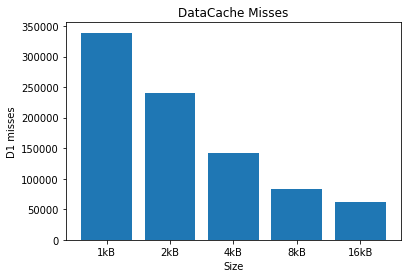

In [ ]:
%%rangecachegrind datacache=(1,2,4,8,16); ways=2; line=32; bargraph=(misses)
 
//////////////////////////////////////////////
// Fibonacci Otimizado 15 entradas////
////////////////////////////////////////////
 
 
#include <stdlib.h>
#include <stdio.h>
 
int fib(int n){
 
  int i, fib1 = 1, fib2 = 1, soma;         
  for (i = 3; i <= n; i = i + 1){
 
    soma = fib1 + fib2;                    
    fib1 = fib2;                           
    fib2 = soma;  
 
  }                                        
     return fib2;                             
}                                          
   
   
 int main(int argc, char const *argv[]){
     int n;
     int Fibo;
     FILE *arquivo;
     arquivo = fopen("Entrada_15.txt","r");
 
     while (!feof(arquivo))
     {
        fscanf(arquivo,"%d\n",&n);
        Fibo = fib(n);
        
     }
    getchar();
 
    fclose(arquivo);
    return 0; 
 
}

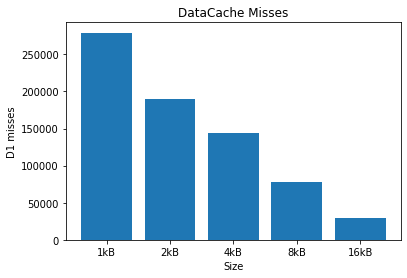

In [ ]:
%%rangecachegrind datacache=(1,2,4,8,16); ways=8; line=128; bargraph=(misses)

///////////////////////////////////////////////
// Fibonacci  Otimizado 15 entradas////
/////////////////////////////////////////////


#include <stdlib.h>
#include <stdio.h>

int fib(int n){

  int i, fib1 = 1, fib2 = 1, soma;         
  for (i = 3; i <= n; i = i + 1){

    soma = fib1 + fib2;                    
    fib1 = fib2;                           
    fib2 = soma;  

  }                                        
     return fib2;                             
}                                          
   
   
 int main(int argc, char const *argv[]){
     int n;
     int Fibo;
     FILE *arquivo;
     arquivo = fopen("Entrada_100.txt","r");

     while (!feof(arquivo))
     {
        fscanf(arquivo,"%d\n",&n);
        Fibo = fib(n);
        
     }
    getchar();

    fclose(arquivo);
    return 0; 

}

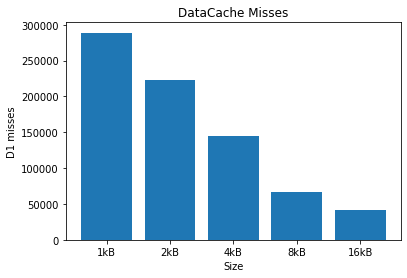

In [ ]:
%%rangecachegrind datacache=(1,2,4,8,16); ways=4; line=64; bargraph=(misses)

/////////////////////////////////////////////
// Fibonacci Otimizado com 15 entradas ////
///////////////////////////////////////////


#include <stdlib.h>
#include <stdio.h>

int fib(int n){

  int i, fib1 = 1, fib2 = 1, soma;         
  for (i = 3; i <= n; i = i + 1){

    soma = fib1 + fib2;                    
    fib1 = fib2;                           
    fib2 = soma;  

  }                                        
     return fib2;                             
}                                          
   
   
 int main(int argc, char const *argv[]){
     int n;
     int Fibo;
     FILE *arquivo;
     arquivo = fopen("Entrada_100.txt","r");

     while (!feof(arquivo))
     {
        fscanf(arquivo,"%d\n",&n);
        Fibo = fib(n);
        
     }
    getchar();

    fclose(arquivo);
    return 0; 

}

# Explicação dos resultados

#Fibonacci otimizado 15 entradas:
  Nesta parte mudamos a associatividade do bloco para os tamanhos 2, 4 e 8, sendo assim, foi possível variar os tamanhos da memória cache, as variações foram 32, 64 e 128. Diante disso, foi utilizado também o mesmo tamanho do bloco de palavras. Outrossim, é notório, segundo os gráficos gerados que quanto maior o tamanho de cache, menor a quantidade de misses.

#1º Gráfico
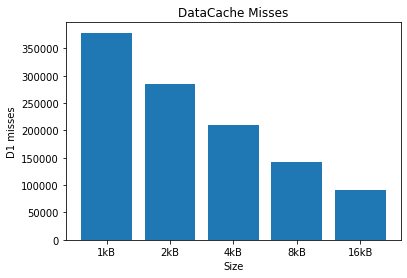
datacache=(1,2,4,8,16); ways=2; line=32; bargraph=(misses)


#2º Gráfico 
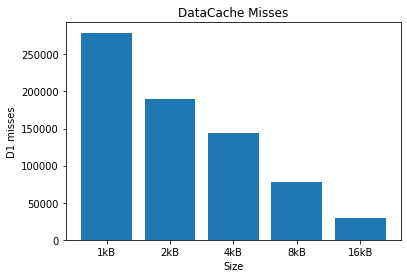
datacache=(1,2,4,8,16); ways=8; line=128; bargraph=(misses)

#3º Gráfico
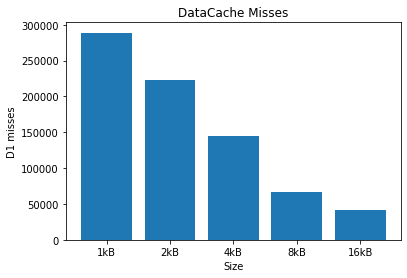
datacache=(1,2,4,8,16); ways=4; line=64; bargraph=(misses)